In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pickle, json

sys.path.append('src')
from constants import BASE_PATH, make_ibl_linear_model_path, DATASET_HELDOUT_INFO_PATH

In [2]:
base_path = BASE_PATH

In [3]:

def load_dfe_results(result_path):
    """Load DFE pickle files from result path."""
    with open(result_path / 'dfe_no_mask_pred.pkl', 'rb') as f:
        dfe_mae = pickle.load(f)
    with open(result_path / 'dfe_no_mask_from_record_to_heldout.pkl', 'rb') as f:
        dfe_baseline = pickle.load(f)
    return dfe_mae, dfe_baseline

def flatten_dfe(dfe_dict: dict, heldout_info: dict, filter: bool = True) -> np.ndarray:
    sess_area_dfe = []
    for eid_ind in dfe_dict.keys():
        area_ind = heldout_info[eid_ind]['heldout_region_ind']
        # for area_ind in dfe_dict[eid_ind].keys():
        sess_area_dfe.append(dfe_dict[eid_ind][area_ind])
    dfe_all = np.concatenate(sess_area_dfe)
    dfe_all = dfe_all[abs(dfe_all) < 1e3]
    if filter:
        dfe_all = dfe_all[dfe_all > np.quantile(dfe_all, 0.01)]
    return dfe_all

def main(filter: bool = True):
    heldout_info = json.load(open(DATASET_HELDOUT_INFO_PATH / f'ibl_heldout_info_{20}.json', 'r'))
    all_means = []
    all_sems = []
    all_xticks = []
    for reg in [False, True]:
        for consistency in [False, True]:
            for smooth in [False, True]:
                try:
                    path = base_path / 'eval' / make_ibl_linear_model_path(reg, consistency, smooth, 20)
                    
                    with open(path / 'dfe_no_mask_pred.pkl', 'rb') as f:
                        dfe_mae = pickle.load(f)
                    mae_stats = flatten_dfe(dfe_mae, heldout_info, filter=filter)
                    all_means.append(np.nanmean(mae_stats))
                    all_sems.append(np.nanstd(mae_stats) / np.sqrt(len(mae_stats)))
                    all_xticks.append(f"reg {int(reg)}\ncons {int(consistency)}\nsmooth {int(smooth)}")
                    print(f'reg {reg}, consistency {consistency}, smooth {smooth}: \t{np.nanmean(mae_stats):.4f} ± {np.nanstd(mae_stats) / np.sqrt(len(mae_stats)):.4f}')
                except FileNotFoundError:
                    pass
    return all_means, all_sems, all_xticks

reg False, consistency False, smooth False: 	-0.0000 ± 0.0022
reg False, consistency False, smooth True: 	0.0208 ± 0.0021
reg False, consistency True, smooth False: 	0.0145 ± 0.0018
reg False, consistency True, smooth True: 	0.0173 ± 0.0022
reg True, consistency False, smooth False: 	-0.0693 ± 0.0076
reg True, consistency False, smooth True: 	0.0132 ± 0.0035
reg True, consistency True, smooth False: 	0.0225 ± 0.0028
reg True, consistency True, smooth True: 	0.0224 ± 0.0022


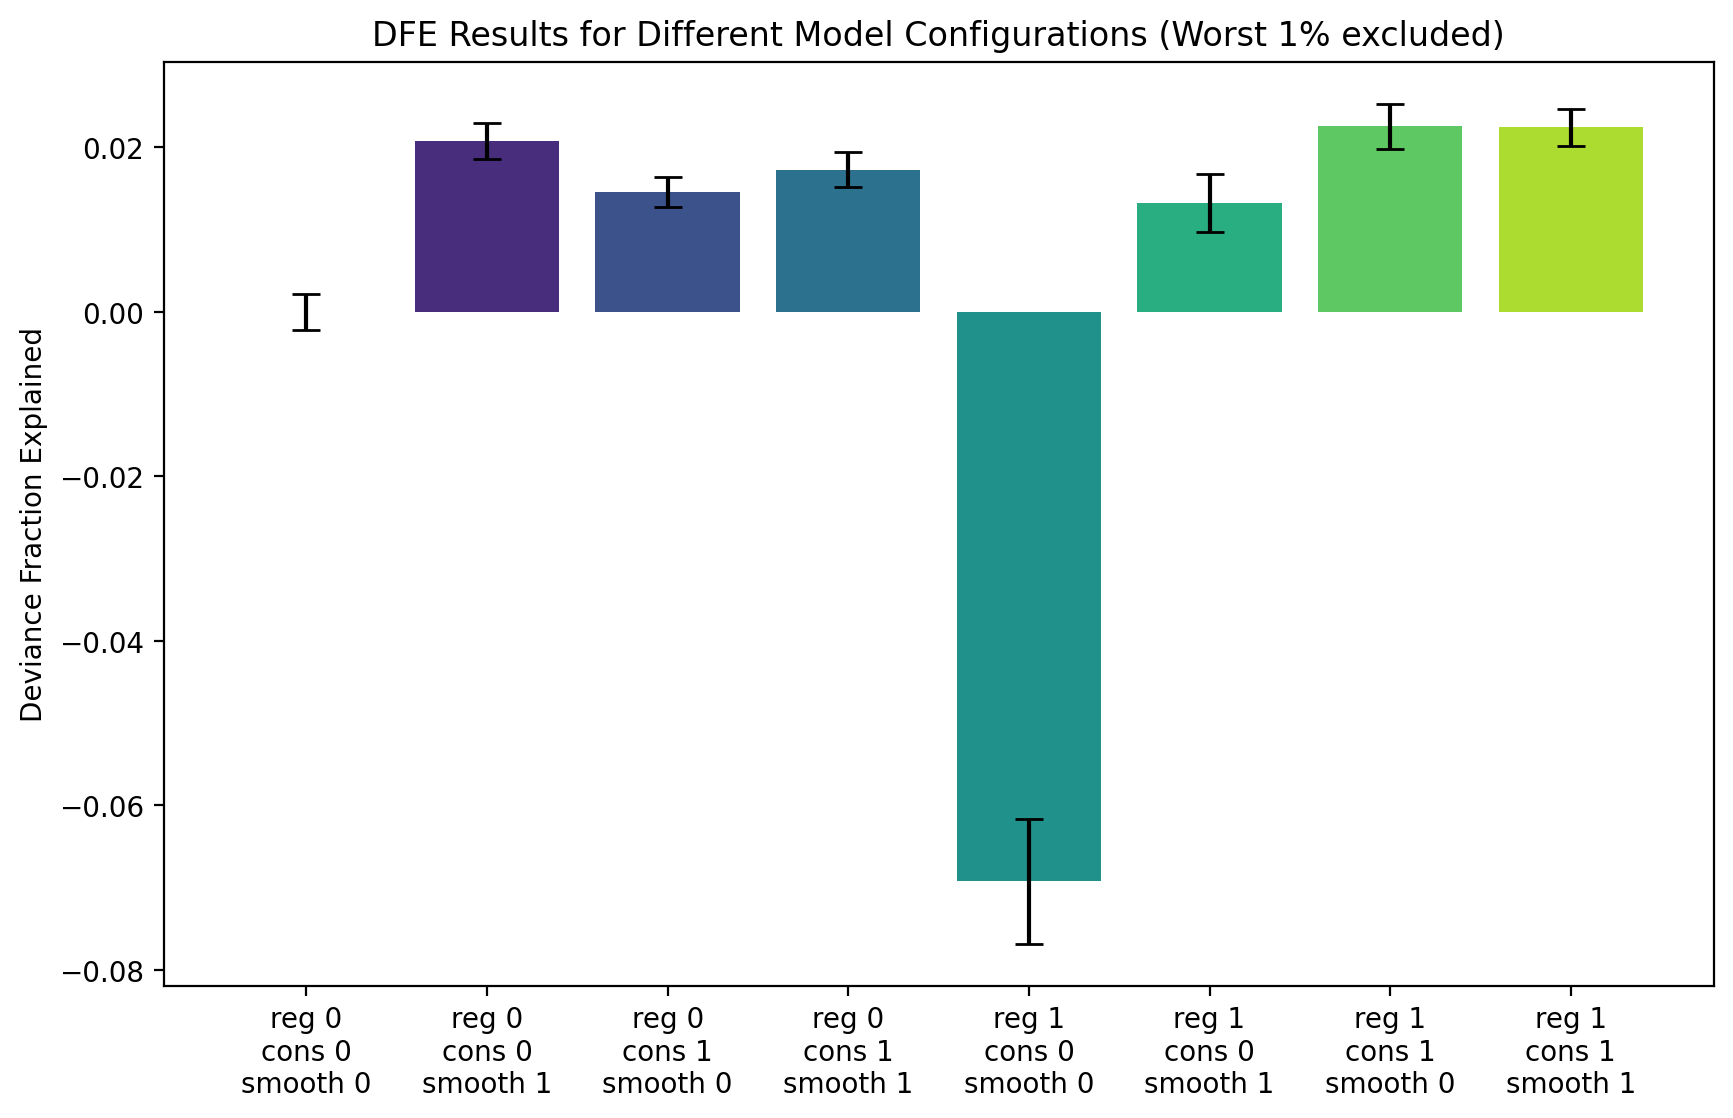

In [4]:
all_means, all_sems, all_xticks = main(filter=True)

plt.figure(figsize=(10, 6))
x = np.arange(len(all_means))
cmap = plt.cm.viridis
colors = [cmap(i / len(all_means)) for i in range(len(all_means))]
plt.bar(x, all_means, yerr=all_sems, capsize=5, color=colors)
plt.xticks(x, all_xticks)
plt.ylabel("Deviance Fraction Explained")
plt.title("DFE Results for Different Model Configurations (Worst 1% excluded)")
plt.show()

reg False, consistency False, smooth False: 	-0.0153 ± 0.0038
reg False, consistency False, smooth True: 	-0.0122 ± 0.0106
reg False, consistency True, smooth False: 	0.0008 ± 0.0035
reg False, consistency True, smooth True: 	-0.0075 ± 0.0082
reg True, consistency False, smooth False: 	-0.0928 ± 0.0086
reg True, consistency False, smooth True: 	-0.0193 ± 0.0073
reg True, consistency True, smooth False: 	-0.0470 ± 0.0120
reg True, consistency True, smooth True: 	-0.1918 ± 0.1819


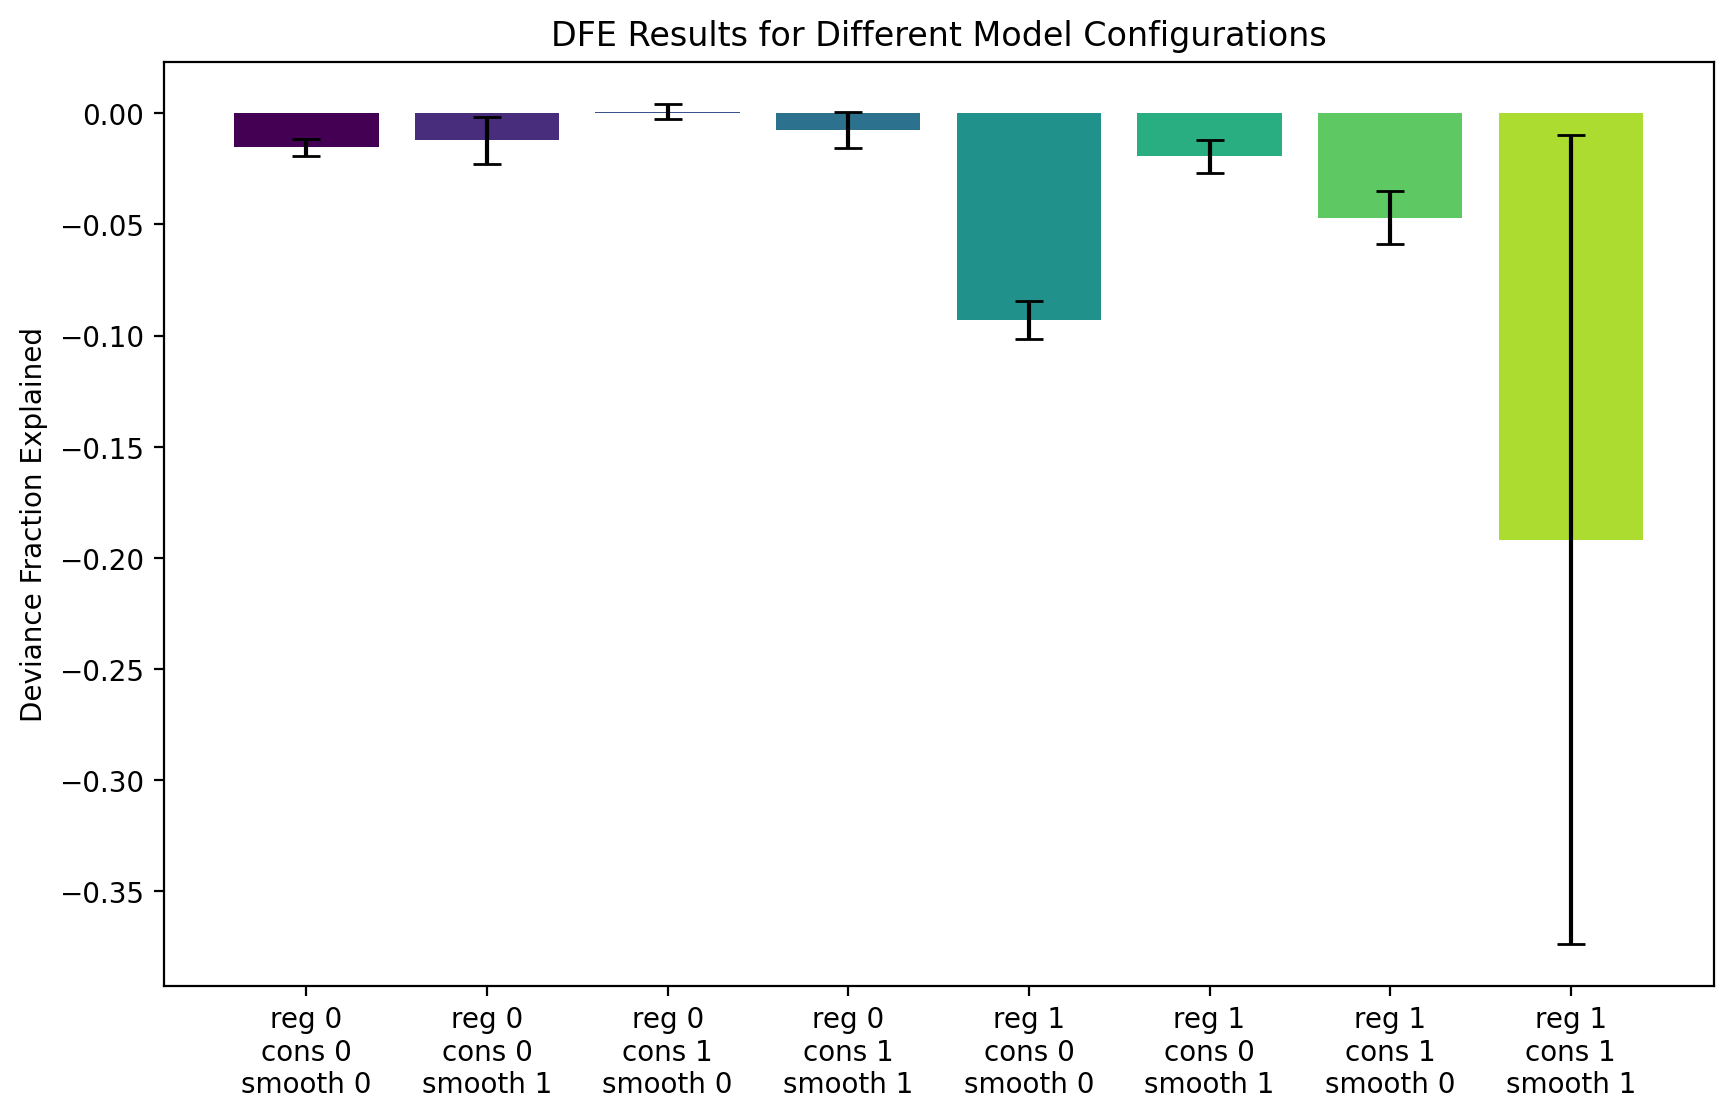

In [5]:
all_means, all_sems, all_xticks = main(filter=False)

plt.figure(figsize=(10, 6))
x = np.arange(len(all_means))
cmap = plt.cm.viridis
colors = [cmap(i / len(all_means)) for i in range(len(all_means))]
plt.bar(x, all_means, yerr=all_sems, capsize=5, color=colors)
plt.xticks(x, all_xticks)
plt.ylabel("Deviance Fraction Explained")
plt.title("DFE Results for Different Model Configurations")
plt.show()

In [6]:
import seaborn as sns
from sklearn.cluster import SpectralClustering

# Load data
heldout_info = json.load(open(DATASET_HELDOUT_INFO_PATH / f'ibl_heldout_info_{20}.json', 'r'))

brain_region_list = ["PO", "LP", "DG", "CA1", "VISa", "VPM", "APN", "MRN"]

# Load all model configurations
all_model_data = {}
for reg in [False, True]:
    for consistency in [False, True]:
        for smooth in [False, True]:
            try:
                path = base_path / 'eval' / make_ibl_linear_model_path(reg, consistency, smooth, 20)
                with open(path / 'dfe_no_mask_pred.pkl', 'rb') as f:
                    dfe = pickle.load(f)
                with open(path / 'mae_no_mask_fr_pred_test_save.pkl', 'rb') as f:
                    fr_pred = pickle.load(f)
                with open(path / 'spike_test_save.pkl', 'rb') as f:
                    spikes = pickle.load(f)
                
                model_name = f"reg={int(reg)}, cons={int(consistency)}, smooth={int(smooth)}"
                all_model_data[model_name] = {'dfe': dfe, 'fr_pred': fr_pred, 'spikes': spikes}
            except FileNotFoundError:
                pass

print(f"Loaded {len(all_model_data)} model configurations")

Loaded 8 model configurations


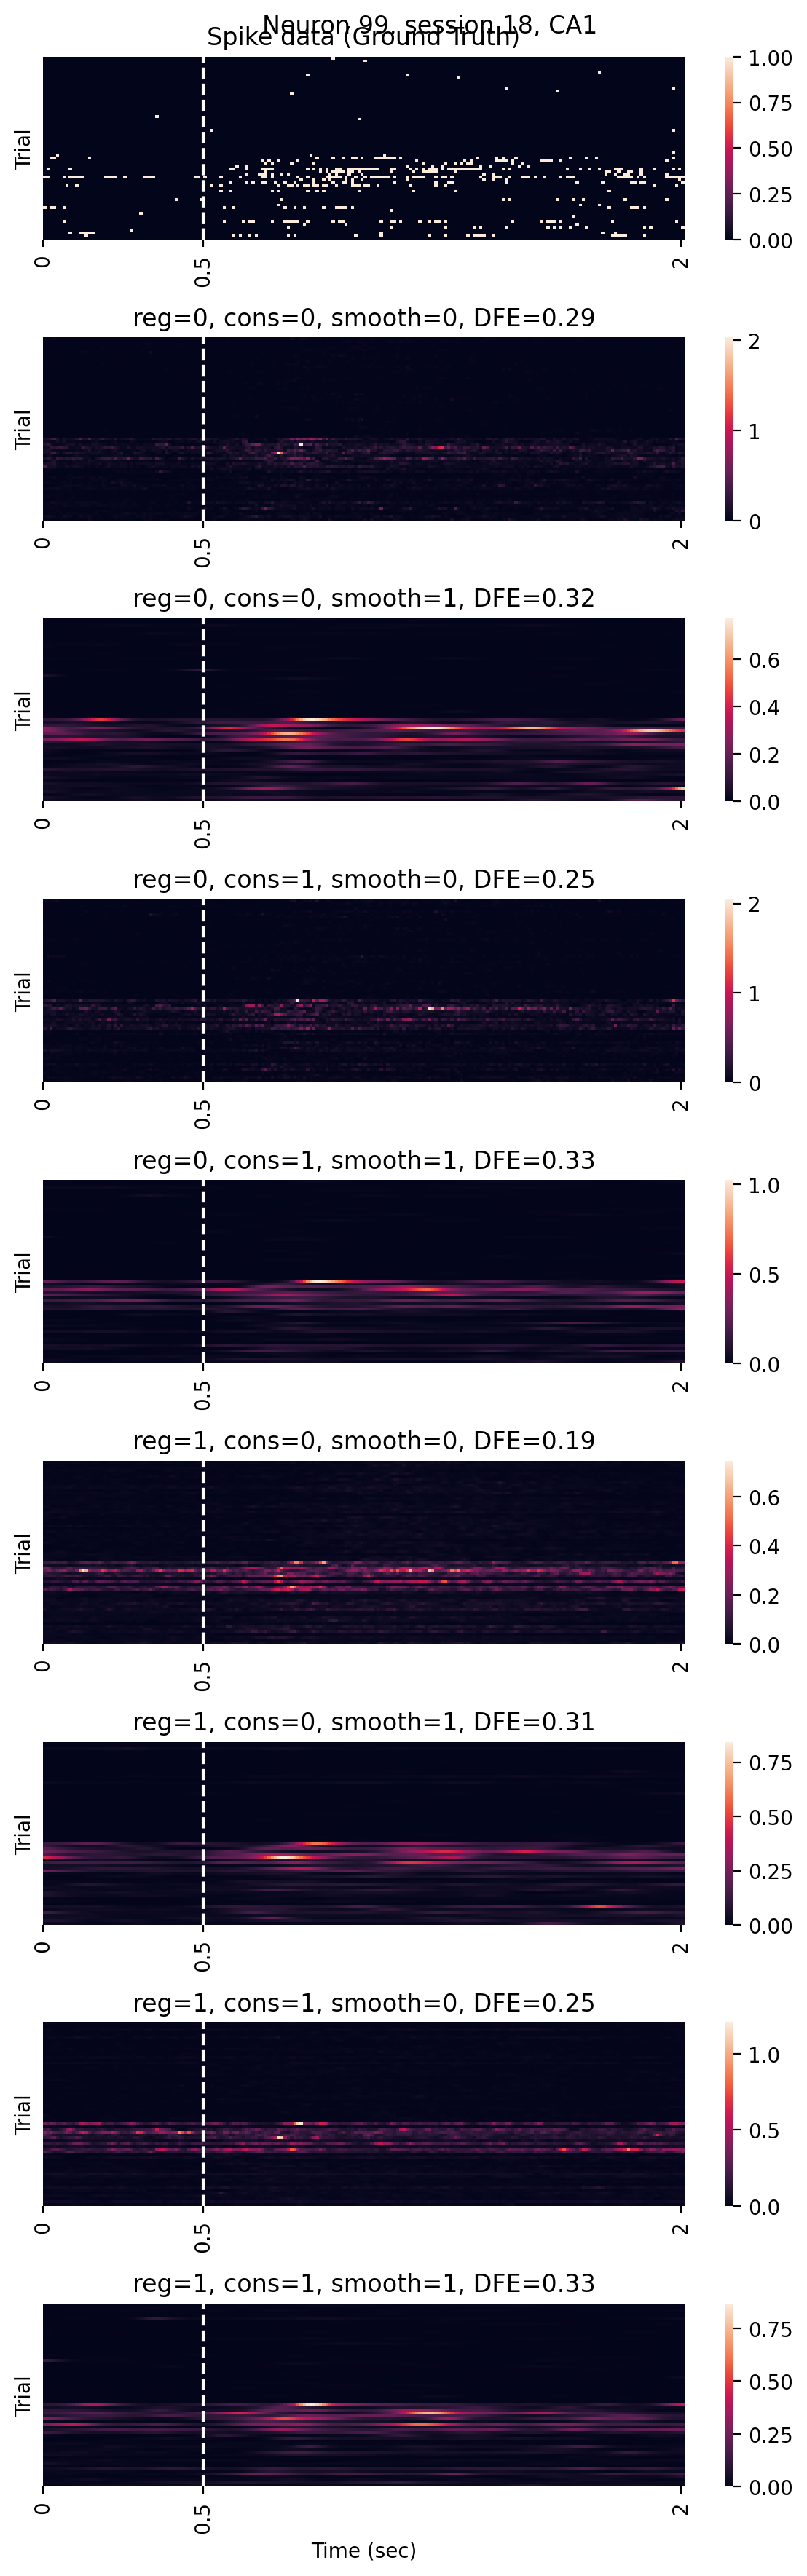

In [7]:
# Select session and region
eid_ind = 18
area_ind = heldout_info[eid_ind]['heldout_region_ind']
eid = eid_ind

# Get reference model for neuron sorting and spike data
ref_model = list(all_model_data.keys())[0]
spike_region_test = all_model_data[ref_model]['spikes'][eid][area_ind]
dfe_ref = all_model_data[ref_model]['dfe'][eid][area_ind]
neuron_id_sort = np.argsort(dfe_ref)[::-1]

# Plot for top neuron across all models
neuron_idx = 0  # Top neuron by DFE
neuron_id = neuron_id_sort[neuron_idx]

# Get trial sorting from first model
tmp = all_model_data[ref_model]['fr_pred'][eid][area_ind][:, :, neuron_id]
clustering = SpectralClustering(n_clusters=3, n_neighbors=5,
                                 affinity='nearest_neighbors',
                                 assign_labels='discretize',
                                 random_state=0)
clustering = clustering.fit(tmp)
trial_sort = np.argsort(clustering.labels_)

n_models = len(all_model_data)
fig, axes = plt.subplots(n_models + 1, 1, figsize=(6, 2 * (n_models + 1)))

# Spike data (ground truth)
ax = axes[0]
sns.heatmap(spike_region_test[:, :, neuron_id][trial_sort], vmin=0, vmax=1, ax=ax, cbar=True)
ax.set_ylabel('Trial')
ax.axvline(50, color='w', linestyle='--')
ax.set_yticks([])
ax.set_xticks([0, 50, 199])
ax.set_xticklabels([0, '0.5', 2])
ax.set_title('Spike data (Ground Truth)')

# Plot each model's prediction
for idx, (model_name, data) in enumerate(all_model_data.items()):
    ax = axes[idx + 1]
    fr_pred = data['fr_pred'][eid][area_ind][:, :, neuron_id]
    dfe_val = data['dfe'][eid][area_ind][neuron_id]
    
    vmax = np.max(fr_pred)
    sns.heatmap(fr_pred[trial_sort], vmin=0, vmax=vmax, ax=ax, cbar=True)
    ax.set_ylabel('Trial')
    ax.axvline(50, color='w', linestyle='--')
    ax.set_yticks([])
    ax.set_xticks([0, 50, 199])
    ax.set_xticklabels([0, '0.5', 2])
    ax.set_title(f'{model_name}, DFE={dfe_val:.2f}')

axes[-1].set_xlabel('Time (sec)')
plt.suptitle(f'Neuron {neuron_id}, session {eid}, {brain_region_list[area_ind]}', fontsize=12)
plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.show()